In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

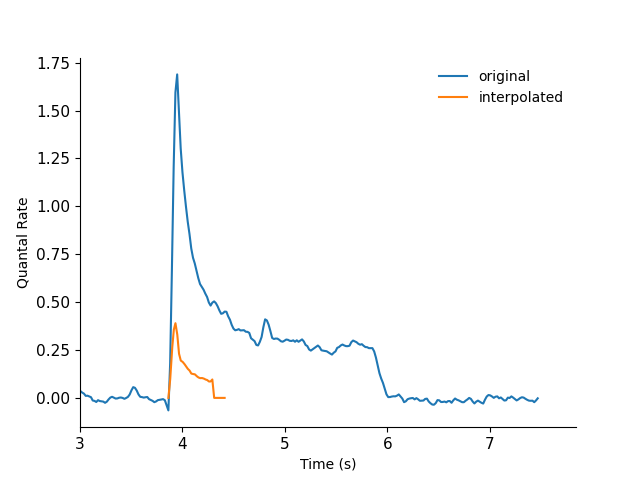

In [4]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.4,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [5]:
model_path = os.path.join(base_path, "gaba_titration")
fig_dir_path = os.path.join(model_path, "figs") 

save_name = "test"
save_name = "exp_tmrho0p9_etau0p54_poisson_6n_3tr_0p0_5p0"

# load_name = "test"
load_name = None

# load_name = "control_6n_3tr_0p1_2p0"
# load_name = "no_nmda_6n_3tr_0p1_2p0"
# load_name = "non_ds_ach_6n_3tr_0p1_2p0"
# load_name = "non_ds_ach_no_nmda_6n_3tr_0p1_2p0"

# load_name = "control_6n_3tr_0p1_2p0_nmda0p004"
# load_name = "control_6n_3tr_0p1_2p0_nmda0p006"
# load_name = "control_6n_3tr_0p2_1p6_ach0p001_nmda0p004"
# load_name = "control_6n_3tr_0p2_1p6_ach0p001_nmda0p006"
# load_name = "control_6n_3tr_0p1_2p0_EIdelay20ms"
# load_name = "control_6n_3tr_0p1_2p0_nmda0p006_EIdelay20ms"

# load_name = "control_6n_3tr_0p0_5p0"
# load_name = "no_nmda_6n_3tr_0p0_3p0"
# load_name = "non_ds_ach_6n_3tr_0p0_3p0"
# load_name = "control_6n_3tr_0p0_3p0_EIdelay20ms"
# load_name = "control_6n_3tr_0p0_5p0_nmda0p004"
# load_name = "control_6n_3tr_0p0_5p0_nmda0p006"

# load_name = "plex2_split_6n_3tr_0p0_5p0"
# load_name = "plex2_share0p5_6n_3tr_0p0_5p0"
# load_name = "plex4_share0p5_6n_3tr_0p0_5p0"

# load_name = "control_poisson_6n_3tr_0p0_5p0"
# load_name = "tmrho0p9_etau0p54_poisson_6n_3tr_0p0_5p0"

model_config = configs.sac_mode_config(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    record_tree=False,
    poisson_rates={"sac": vrate * 1., "glut": vrate * 1., "dt": target_rate_dt},
    plexus=0,
    plexus_share=0.5,
)

model_config["time_rho"] = 0.9
model_config["synprops"]["E"]["tau2"] = 0.54
model_config["sac_theta_mode"] = "experimental"

# model_config["synprops"]["E"]["weight"] = 0.001

# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0
# model_config["synprops"]["NMDA"]["weight"] = 0.006

# model_config["synprops"]["E"]["delay"] += 20
# model_config["synprops"]["I"]["delay"] += 20

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_gaba_titration_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        # gaba_steps=[0.5, 1.],
        gaba_steps=[
            0.0, 0.025, 0.05, 
            0.1, 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6, 1.8, 2.0,
            3.0, 4.0, 5.0
        ],
        pool_sz=6,
    )

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)

factors = list(d.keys())
rhos = list(d[factors[0]].keys())
idxs = list(d[factors[0]][rhos[0]].keys())
print("==keys==")
print("factors:", factors)
print("rhos:", rhos)
print("idxs:", idxs)

Running with GABA scaled by factor of 0.00
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.03
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.05
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.10
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.20
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.40
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.60
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 0.80
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 1.00
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 1.20
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 1.40
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 1.60
  sac net trials 1 to 6 (of 6)...
Running with GABA scaled by factor of 1.80
  sac net trials 1 to 6 (of 6)...

In [6]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [7]:
metrics = {k: ana.get_sac_metrics(d[k]) for k in factors}

dir_labels = d[factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = ana.get_sac_thetas(d[factors[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)

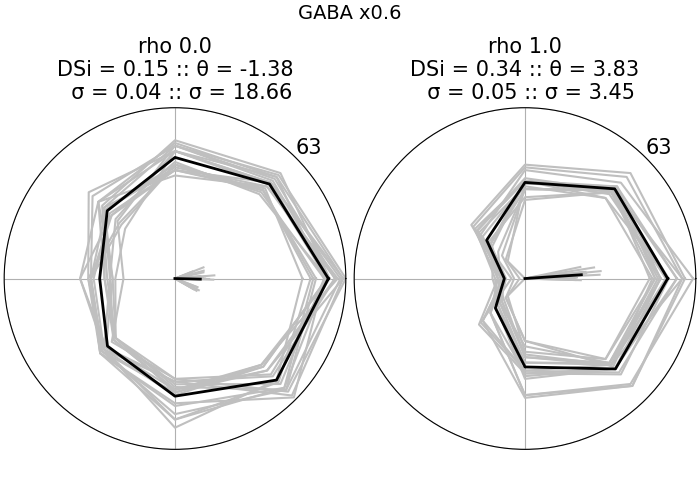

In [22]:
factor = 0.6
max_spikes = np.max([r["spikes"] for r in metrics[factor].values()])
focus_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
focus_polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=focus_polar_fig,
        sub_loc=(1, n_cols, loc + 1),
    )
    for loc, (r, m) in enumerate(metrics[factor].items())
]
focus_polar_fig.suptitle("GABA x%.1f" % factor, fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
focus_polar_fig.savefig(os.path.join(fig_path, "gaba_x%.1f_polars.png" % factor), bbox_inches="tight")

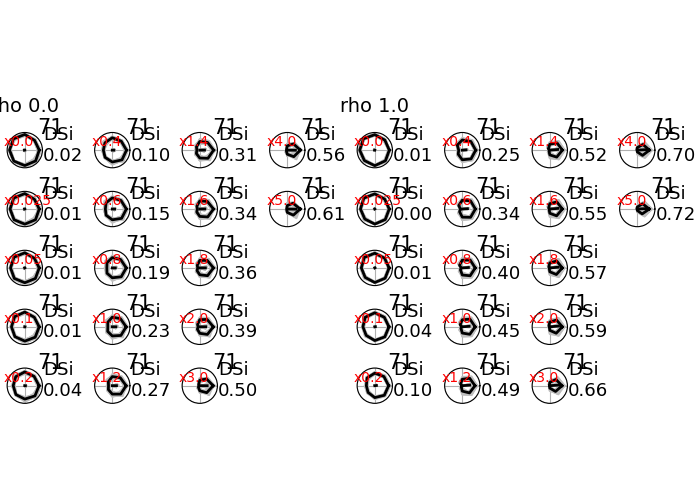

In [9]:
max_spikes = np.max([r["spikes"] for s in factors for r in metrics[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(factors))
splits = int(np.ceil(len(factors) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, (rho, m) in enumerate(metrics[factor].items()):
        polar_ax.append(polar_plot(
            m,
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=False,
            save=False,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i in range(len(rhos)):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14, pad=15)

polar_fig.set_layout_engine("compressed")
polar_fig.savefig(os.path.join(fig_path, "polar_grid.png"), bbox_inches="tight")

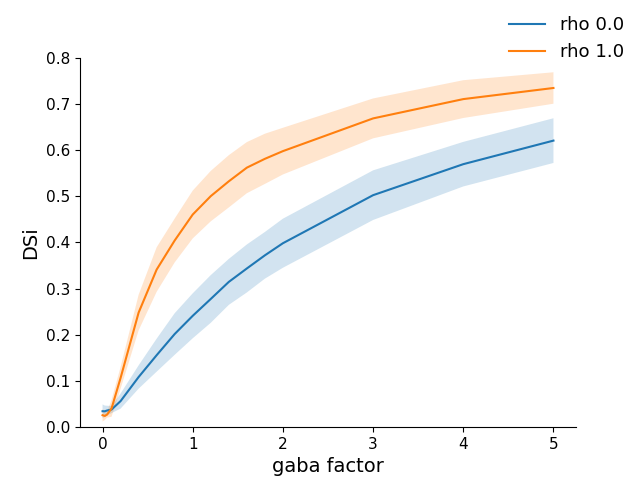

In [10]:
dsi_fig, dsi_ax = plt.subplots(1)

titration_dsis = {}
for rho in rhos:
    titration_dsis[rho] = {"nets": [], "avg": [], "std": []}
    for factor in factors:
        dsis = metrics[factor][rho]["DSis"]
        dsi_net_avgs = metrics[factor][rho]["DSis"].mean(axis=1)
        titration_dsis[rho]["nets"].append(dsi_net_avgs)
        titration_dsis[rho]["avg"].append(np.mean(dsi_net_avgs))
        titration_dsis[rho]["std"].append(np.std(dsi_net_avgs))
    titration_dsis[rho] = {m: np.array(v) for m, v in titration_dsis[rho].items()}
    titration_dsis[rho]["nets"] = titration_dsis[rho]["nets"].T
    dsi_ax.fill_between(
        factors, 
        titration_dsis[rho]["avg"] + titration_dsis[rho]["std"],
        titration_dsis[rho]["avg"] - titration_dsis[rho]["std"],
        alpha=0.2
    )
    dsi_ax.plot(factors, titration_dsis[rho]["avg"], label="rho " + str(rho))
        
dsi_ax.set_ylabel("DSi", fontsize=14)
dsi_ax.set_xlabel("gaba factor", fontsize=14)
# dsi_ax.set_xscale("log")
dsi_ax.set_ylim(0, 0.8)

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax)
dsi_fig.savefig(os.path.join(fig_path, "dsi.png"), bbox_inches="tight")

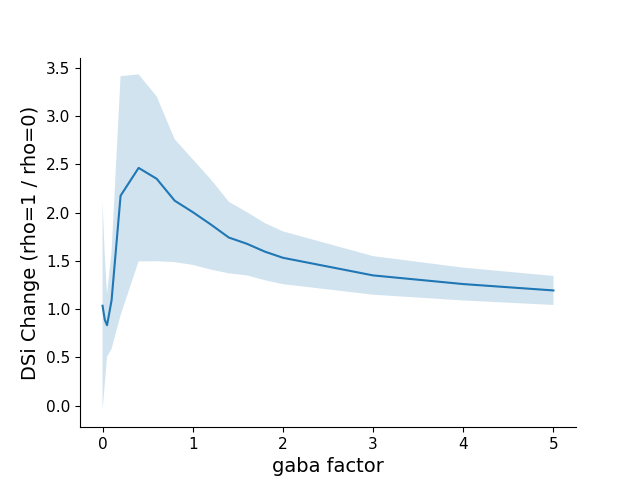

In [11]:
rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
dsi_effect_nets = titration_dsis[1.0]["nets"] / titration_dsis[0.0]["nets"]
dsi_effect_avg = np.mean(dsi_effect_nets, axis=0)
dsi_effect_std = np.std(dsi_effect_nets, axis=0)

rho_dsi_effect_ax.fill_between(
    factors, 
    dsi_effect_avg + dsi_effect_std,
    dsi_effect_avg - dsi_effect_std,
    alpha=0.2
)
rho_dsi_effect_ax.plot(factors, dsi_effect_avg)

rho_dsi_effect_ax.set_ylabel("DSi Change (rho=1 / rho=0)", fontsize=14)
rho_dsi_effect_ax.set_xlabel("gaba factor", fontsize=14)
# rho_dsi_effect_ax.set_xscale("log")

clean_axes(rho_dsi_effect_ax)
rho_dsi_effect_fig.savefig(os.path.join(fig_path, "dsi_effect_of_rho.png"), bbox_inches="tight")

In [12]:
avg_spikes = {
    fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}
std_spikes = {
    fac: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}

wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

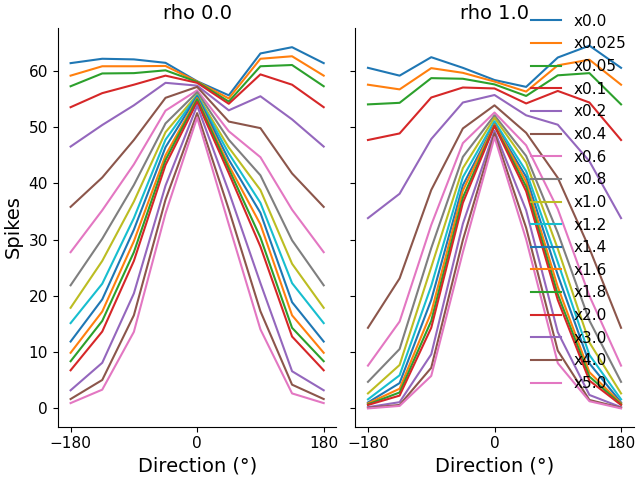

In [13]:
tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True)
for i, (ax, rho) in enumerate(zip(tuning_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    for factor in factors:
        lbl = ("x" + str(factor)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_spikes[factor][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")
tuning_fig.savefig(os.path.join(fig_path, "tuning.png"), bbox_inches="tight")

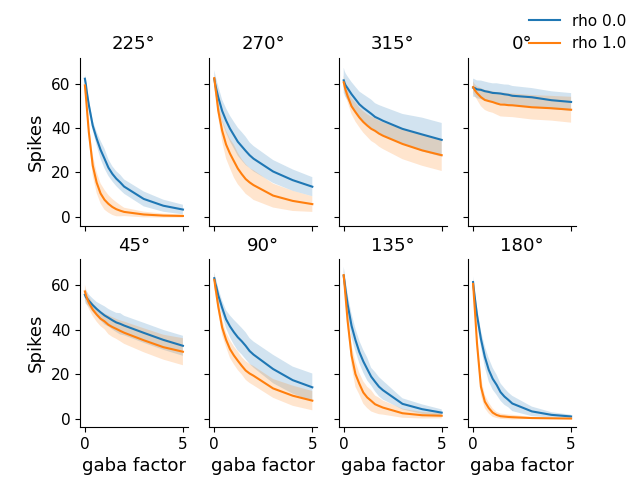

In [14]:
dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes", fontsize=13)
    for ax in row:
        for rho in rhos:
            spks = np.array([avg_spikes[factor][rho][i] for factor in factors])
            stds = np.array([std_spikes[factor][rho][i] for factor in factors])
            lbl = ("rho " + str(rho)) if not i else None
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)
dir_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_grid.png"), bbox_inches="tight")

/tmp/ipykernel_2183/2485925131.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(factors, rho0_spks / rho1_spks)


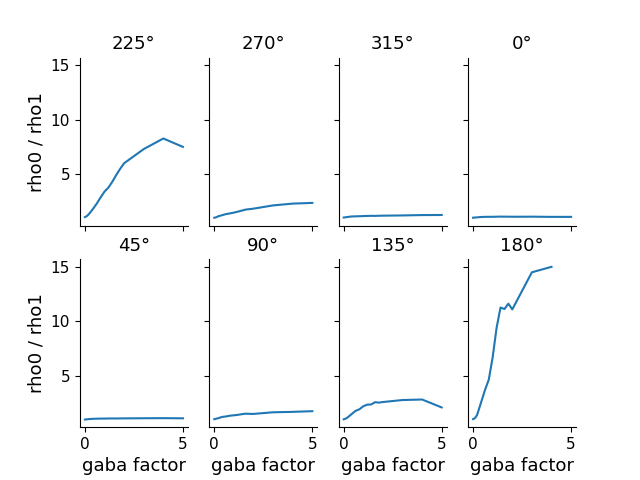

In [15]:
dir_mult_grid_fig, dir_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1", fontsize=13)
    for ax in row:
        rho0_spks = np.array([avg_spikes[factor][0.0][i] for factor in factors])
        rho1_spks = np.array([avg_spikes[factor][1.0][i] for factor in factors])
        ax.plot(factors, rho0_spks / rho1_spks)
        ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_mult_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)
        
clean_axes(dir_mult_grid_ax)
dir_mult_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_effect_of_rho_grid.png"), bbox_inches="tight")

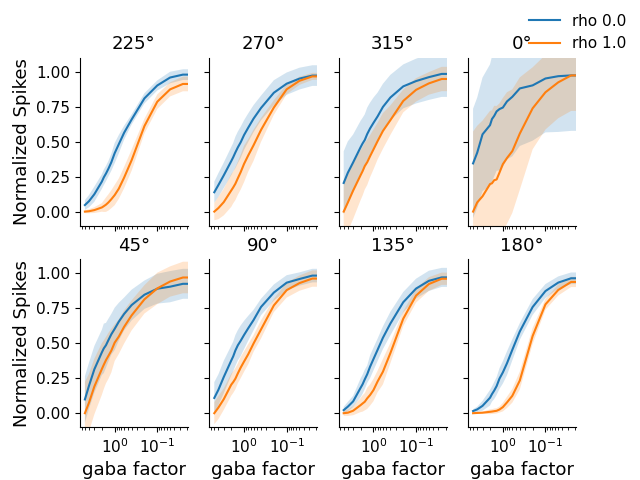

In [16]:
norm_dir_grid_fig, norm_dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

norm_dir_spikes, norm_dir_stds = [], []
for i in range(len(dir_labels)):
    spks = np.stack([[avg_spikes[factor][rho][i] for factor in factors] for rho in rhos], axis=0)
    stds = np.stack([[std_spikes[factor][rho][i] for factor in factors] for rho in rhos], axis=0)
    min_spks = np.min(spks)
    max_spks = np.max(spks)
    spks = (spks - min_spks) / (max_spks - min_spks)
    stds = stds / (max_spks - min_spks)
    norm_dir_spikes.append(spks)
    norm_dir_stds.append(stds)
norm_dir_spikes = np.stack(norm_dir_spikes, axis=0)
norm_dir_stds = np.stack(norm_dir_stds, axis=0)
    
i = 0
for row in norm_dir_grid_ax:
    row[0].set_ylabel("Normalized Spikes", fontsize=13)
    for ax in row:
        for j, rho in enumerate(rhos):
            lbl = ("rho " + str(rho)) if not i else None
            spks = norm_dir_spikes[i, j]
            stds = norm_dir_stds[i, j]
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in norm_dir_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)
        
norm_dir_grid_ax[0, 0].set_ylim(-0.1, 1.1)
norm_dir_grid_ax[0, 0].invert_xaxis()
norm_dir_grid_ax[0, 0].set_xscale("log")
norm_dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(norm_dir_grid_ax)
norm_dir_grid_fig.savefig(os.path.join(fig_path, "norm_dir_spikes_grid.png"), bbox_inches="tight")

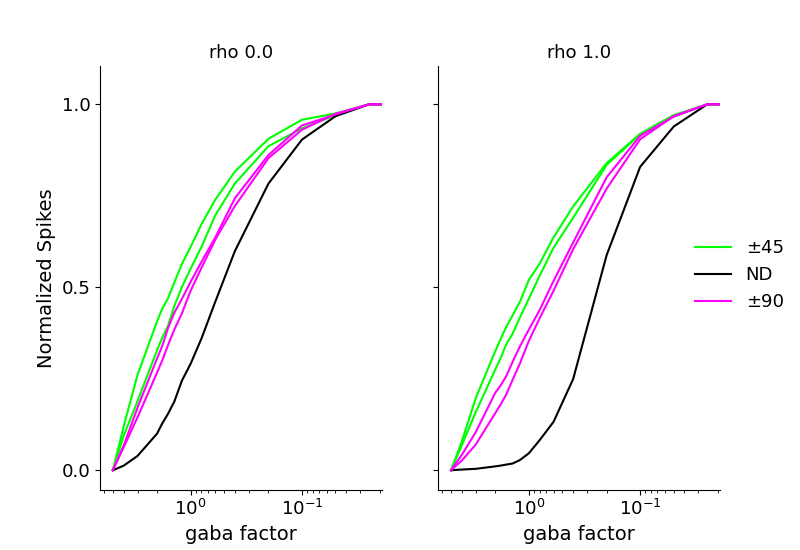

In [17]:
fctrs = factors[:]
# fctrs = factors[4:]
norm_rho_dir_spikes, norm_rho_dir_stds = [], []
for i in range(len(dir_labels)):
    spks = np.stack([[avg_spikes[factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
    stds = np.stack([[std_spikes[factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
    # if gaba factor x0.0 is included, lines will not reach spiking=1 on the log plot
    min_spks = np.min(spks[:, 1:], axis=1, keepdims=True) 
    max_spks = np.max(spks[:, 1:], axis=1, keepdims=True)
    spks = (spks - min_spks) / (max_spks - min_spks)
    stds = stds / (max_spks - min_spks)
    norm_rho_dir_spikes.append(spks)
    norm_rho_dir_stds.append(stds)
norm_rho_dir_spikes = np.stack(norm_rho_dir_spikes, axis=0)
norm_rho_dir_stds = np.stack(norm_rho_dir_stds, axis=0)

log_titration_fig, log_titration_ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5.5))
for r, ax in enumerate(log_titration_ax):
    ax.plot(fctrs, norm_rho_dir_spikes[2, r], label="±45" if r else None, c="lime")  # 45
    ax.plot(fctrs, norm_rho_dir_spikes[4, r], c="lime")  # 315
    # ax.fill_between(
    #     fctrs, 
    #     norm_rho_dir_spikes[7, r] + norm_rho_dir_stds[7, r],
    #     norm_rho_dir_spikes[7, r] - norm_rho_dir_stds[7, r],
    #     alpha=0.2, color="black"
    # )
    ax.plot(fctrs, norm_rho_dir_spikes[7, r], label="ND" if r else None, c="black")  # 180
    ax.plot(fctrs, norm_rho_dir_spikes[1, r], label="±90" if r else None, c="magenta")  # 270
    ax.plot(fctrs, norm_rho_dir_spikes[5, r], c="magenta")  # 90
    ax.set_title("rho %.1f" % rhos[r], fontsize=13)
    ax.set_xlabel("gaba factor", fontsize=14)

# from matplotlib.scale import LogScale
log_titration_ax[0].set_yticks([0, 0.5, 1.0])
log_titration_ax[0].set_ylabel("Normalized Spikes", fontsize=14)
log_titration_ax[0].invert_xaxis()
log_titration_ax[0].set_xscale("log")
log_titration_fig.legend(frameon=False, loc="right", fontsize=13)
clean_axes(log_titration_ax, ticksize=13)
log_titration_fig.savefig(os.path.join(fig_path, "log_titration.png"), bbox_inches="tight")

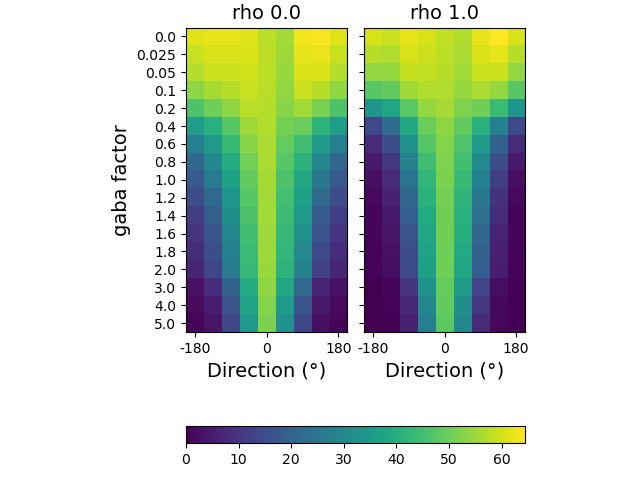

In [18]:
tuning_mat_fig, tuning_mat_ax = plt.subplots(1, 2, sharey=True)

avg_spike_mats = {
    rho: np.stack(
        [wrap_circ(avg_spikes[factor][rho][dir_sort]) for factor in factors], axis=0)
    for rho in rhos
}
avg_max_spikes = np.max([m.max() for m in avg_spike_mats.values()])
avg_spike_imgs = {}

vmax = avg_max_spikes
# vmax = 20.0

for i, (ax, rho) in enumerate(zip(tuning_mat_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    avg_spike_imgs[rho] = ax.imshow(avg_spike_mats[rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(factors)))
    ax.set_yticklabels(factors)
    
tuning_mat_ax[0].set_ylabel("gaba factor", fontsize=14)
tuning_mat_fig.colorbar(
    avg_spike_imgs[rhos[-1]], ax=tuning_mat_ax, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")
tuning_mat_fig.savefig(os.path.join(fig_path, "tuning_matrices.png"), bbox_inches="tight")

In [19]:
close_button()